In [2]:
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from generate_data import ARData, fixed_ar_coefficients
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import os
from torchvision.transforms import transforms
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [28]:
#ZXY = Altered point
num_epochs = 200
learning_rate = 0.1
batch_size = 32
dtype = torch.long
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [29]:
device

device(type='cuda', index=0)

#Dataset structure#
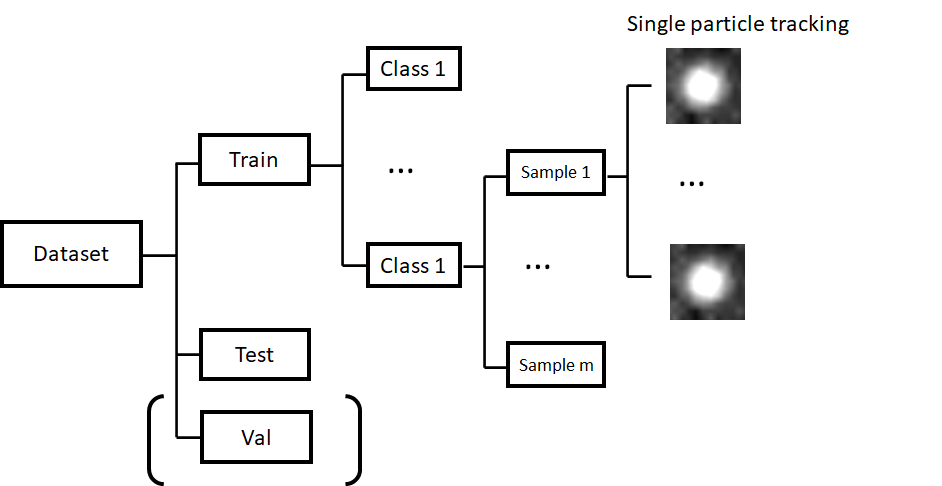

In [30]:
#required size Resnet 224, 224
#              Inception v3 N x 3 x 299 x 299
resize  = torchvision.transforms.Resize((224, 224))
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])## need mean and std
preprocessor = torchvision.transforms.Compose([ 

                                               resize,
                                               torchvision.transforms.ToTensor(), 
                                               normalize,
                                               ])
preprocessor2 = torchvision.transforms.Compose([ 
                                               #torchvision.transforms.RandomRotation(20),
                                               #torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.ToTensor(), #ToTensor transforms the image to a tensor with range [0,1]
                                               
                                               ])

In [36]:
# custom dataset
class MyDataset_3D(Dataset):
    def __init__(self, data_path, transforms=None):
        self.path = data_path
        #self.y = labels
        self.transforms = transforms
        self.classes, self.class_to_idx = self.find_classes()
        self.folders = self.folder_loader()
        print(self.class_to_idx)
    
    def find_classes(self):
        classes = os.listdir(self.path)
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    #load all video folders into the list
    def folder_loader(self):
        folders = []
        for num in self.classes:
            class_dir = os.path.join(self.path, num)
            one_class_folders = os.listdir(class_dir)
            one_class_folders = [os.path.join(class_dir, i) for i in one_class_folders]
            folders += one_class_folders
            
        return folders
             
        
    def __len__(self):
        
        return (len(self.folders))
    
    def frame_average(self, X, average = 5):
        timesteps, C, H, W = X.size()
        
        X_averaged = []
        for i in range(0, timesteps-average-1, average):
            X_averaged.append(X[i:i+average].mean(0))
        X_averaged.append(X[-average:].mean(0))
        
        return torch.stack(X_averaged, dim = 0)
            
            
        
    def read_images(self, one_folder):
        X = []
        frames = os.listdir(one_folder)
        for frame in frames:
            #pay attenention to convert type
            #Image.open().convert('L') 
            #print(os.path.join(one_folder, frame))
            image = Image.open(os.path.join(one_folder, frame))
            #ZXY
            #image = image.resize(size = (20,20))
            if self.transforms:
                image = self.transforms(image)
            else:
                image = torch.tensor(image)    
            
            image = image.float()

            X.append(image)
            #print(image.shape)
            
          
        X = torch.stack(X, dim = 0)
        
        #normalize X over the single particle whole track
        Xmax = torch.max(X)
        Xmin = torch.min(X)
        X = (X-Xmin)/(Xmax-Xmin)
        X = (X-torch.mean(X))/torch.std(X)
        
        #X = self.frame_average(X)
        #print(X.shape)
        
        #ZXY elongate time series
        X = torch.cat((X,torch.flip(X, [0]),X), dim = 0)
        X = torch.cat((X,torch.flip(X, [0]),X), dim = 0)
        
#         ZXY change input dim
        X = X.view(-1,4,10,10)

        return X
        
        
    def __getitem__(self, index):
        X = []
        
        folder = self.folders[index]
        #print(folder)
        class_name = os.path.basename(os.path.dirname(folder)) 
        #print(class_name)
        X = self.read_images(folder)

        #print(self.class_to_idx)
        y = torch.LongTensor([self.class_to_idx[class_name]])
        #print(y)

        return X, y
    
#     image = Image.open('C:\\Users\\ZXY\\Desktop\\ASU\\Lab\\CellClassfier\\dataset1\\0_5um\\ID1\\000001.tif')
#     pixels = list(image.getdata())

In [37]:
Dataset_path = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\dataset_aug_1\train_2'
train_data = MyDataset_3D(Dataset_path, preprocessor2)

train_loader = DataLoader(train_data, batch_size, shuffle=True)

{'0_5um': 0, 'Ecoli': 1}


In [38]:
Dataset_path = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\dataset1\test'
test_data = MyDataset_3D(Dataset_path, preprocessor2)

test_loader = DataLoader(test_data, batch_size, shuffle=True)

{'0_5um': 0, 'Ecoli': 1}


In [39]:
Dataset_path = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\dataset1\val'
val_data = MyDataset_3D(Dataset_path, preprocessor2)

val_loader = DataLoader(val_data, batch_size, shuffle=True)

{'0_5um': 0, 'Ecoli': 1}


In [40]:
for i, (X_batch, labels_batch )in enumerate(train_loader):
    print(X_batch.shape)
    print(labels_batch)
    break

torch.Size([32, 225, 4, 10, 10])
tensor([[0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0]])


In [41]:
# for i, (X_batch, labels_batch )in enumerate(test_loader):
#     print(X_batch.shape)
#     print(labels_batch)
#     break

In [42]:
# predict
def predict(model, loader):
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_predicted = []
        labels_total = []       
        
        for images, labels in loader:
            images = images.to(device,dtype=torch.float)
            labels = labels.squeeze().to(device)

            outputs, _ = model.forward(images)
                
            _, predicted = torch.max(outputs.data, 1)# _ are max values, predicts are their indexs
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted += predicted.cpu().numpy().tolist()
            labels_total += labels.cpu().numpy().tolist()
#             print(outputs)
#             print('predicted',predicted)
#             print('labels', labels)
#             print(correct)
#             print(total)
#             print(predicted == labels)

        print("Accuracy: {}%" .format(100* correct/total),'correct', correct, 'total',total)
    model.train()
    return all_predicted, labels_total, format(100* correct/total)

In [43]:
#####################
# Build model
#####################

# Here we define our model as a class
class CNN_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(CNN_LSTM, self).__init__()
        self.input_ch = input_ch
        self.ch1, self.ch2 = 16, 32 
        self.cnn_embed_dim = 1 #cnn-embedded dim 
        self.k1, self.k2 = 5, 5
        self.h_d = 32
        self.num_layers = 2
        self.N_classes = N_classes

        self.cnn1 = nn.Conv2d(self.input_ch, self.ch1, self.k1)
        self.cnn2 = nn.Conv2d(self.ch1, self.ch2, self.k2)

        self.fc1 = nn.Linear(((20-self.k1+1)-self.k2+1)**2 * self.ch2, self.cnn_embed_dim) # 10 is image size
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.cnn1(cnn_in)
        x = nn.functional.relu(x)

        x = self.cnn2(x)
        x = nn.functional.relu(x)
        
        print(x.shape)
        x = x.view(-1, ((20-self.k1+1)-self.k2+1)**2 * self.ch2)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        print(x.shape)
        
        embed = x

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed
    
class Linear_LSTM(nn.Module):
    def __init__(self, input_ch = 4, N_classes = 2):
        super(Linear_LSTM, self).__init__()
        self.input_ch = input_ch 
        self.cnn_embed_dim = 1 #cnn-embedded dim 
        self.h_d = 8
        self.num_layers = 2
        self.N_classes = N_classes

        self.fc1 = nn.Linear(10*10, self.cnn_embed_dim, bias = False) # 10 is image size
#         self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        self.lstm = nn.LSTM(self.input_ch, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.fc1.weight.data.fill_(0.01)
        self.softmax = nn.Softmax()
      
    #separate operations on each channel
    def divide_inputs(self,X):
        batch_size, timesteps, C, H, W = X.size()
        x  =  X.view(batch_size*timesteps, C, H*W)
        embed = self.fc1(x[:,0,:])

        for i in range(C-1):
            embed = torch.cat((embed,self.fc1(x[:,i+1,:])), dim = 1)

        return embed             

    def forward(self, X_stacked):
        
#         print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        
#         x  =  X_stacked.view(batch_size*timesteps, C*H*W)#need to be checked
        
#         x = self.fc1(x)
#         x = nn.functional.relu(x)
        x = self.divide_inputs(X_stacked)
        
        embed = x

        lstm_out, (h_n, h_c) = self.lstm(x.view(timesteps, batch_size, self.input_ch))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed

#this model is constructed to mimic extracting 1d time information
class Linear_CNN1D(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Linear_CNN1D, self).__init__()
        self.input_ch = input_ch         
        self.ch1, self.ch2, self.ch3 = 6, 16, 26 
        self.k1, self.k2, self.k3 = 5, 5, 3


        self.embed_dim = 1 #cnn-embedded dim 

        self.N_classes = N_classes

        self.cnn1 = nn.Conv1d(self.input_ch, self.ch1, self.k1, stride=2)
        self.cnn2 = nn.Conv1d(self.ch1, self.ch2, self.k2, stride=2)
        self.cnn3 = nn.Conv1d(self.ch2, self.ch3, self.k3, stride=2)
        
        self.fc1 = nn.Linear(1*10*10, self.embed_dim) # 10 is image size
        self.fc2 = nn.Linear(26, 8)
        self.fc3 = nn.Linear(8, self.N_classes)
        
        self.fc1.weight.data.fill_(0.01)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        

        batch_size, timesteps, C, H, W = X_stacked.size()
        x  =  X_stacked.view(batch_size*timesteps, C*H*W)#need to be checked
        
        x = self.fc1(x)
        #x = nn.functional.leaky_relu(x)

        x = x.view(batch_size, 1, -1)
        emd = x

        x = nn.functional.max_pool1d(self.cnn1(x),2)
        x = nn.functional.max_pool1d(self.cnn2(x),2)
        x = nn.functional.max_pool1d(self.cnn3(x),2)

        x = x.view(-1, self.num_flat_features(x))
        x = nn.functional.relu(self.fc2(x))

        y_pred = self.fc3(x)

        y_pred = self.softmax(y_pred)

        return y_pred, emd
    
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [44]:
#####################
# Build model
#####################
class newresnet(torch.nn.Module):
    def __init__(self):
        super(newresnet, self).__init__()

        self.newresnet18  = torchvision.models.resnet18(pretrained = True)
        # for param in self.newresnet18.parameters():
        #     param.requires_grad = False
        # here in_feature is 512*block.expansion
        num_ftrs = self.newresnet18.fc.in_features 

        # remove the last fc layer
        # myresnet = torch.nn.Sequential(*list(myresnet.children())[:-1])
        self.newresnet18.fc = torch.nn.Identity()
        self.fc = torch.nn.Linear(num_ftrs, num_classes)
    def forward(self,x):
        x = self.newresnet18(x)
        # x = torch.flatten(x,1)
        x = self.fc(x)
        return x

class Resnet_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Resnet_LSTM, self).__init__()
        self.input_ch = input_ch 
        self.h_d = 16
        self.num_layers = 2
        self.N_classes = N_classes
        
        self.newresnet18  = torchvision.models.resnet18(pretrained = True)

        self.cnn_embed_dim = self.newresnet18.fc.in_features 

        self.newresnet18.fc = torch.nn.Identity()
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        X_stacked = torch.cat((X_stacked,X_stacked,X_stacked), dim = 2)
        batch_size, timesteps, C, H, W = X_stacked.size()
        
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.newresnet18(cnn_in)

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred

In [45]:
# model = CNN_LSTM()
# model = Resnet_LSTM()
model = Linear_LSTM()
# model = Linear_CNN1D()
model.to(device)

Linear_LSTM(
  (fc1): Linear(in_features=100, out_features=1, bias=False)
  (lstm): LSTM(4, 8, num_layers=2)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

optimizer = torch.optim.Adam([{'params':model.fc1.parameters(), 'lr': 0},
                              {'params':model.fc2.parameters()},
                              {'params':model.lstm.parameters()}
                             ], 
                             lr = learning_rate)

In [47]:
#For updating learning rate
def update_lr(opt, divide = 2):
    for param_group in opt.param_groups:
        param_group['lr'] = param_group['lr']/divide

In [48]:
# Print model's state_dict
print(model)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Linear_LSTM(
  (fc1): Linear(in_features=100, out_features=1, bias=False)
  (lstm): LSTM(4, 8, num_layers=2)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)
Model's state_dict:
fc1.weight 	 torch.Size([1, 100])
lstm.weight_ih_l0 	 torch.Size([32, 4])
lstm.weight_hh_l0 	 torch.Size([32, 8])
lstm.bias_ih_l0 	 torch.Size([32])
lstm.bias_hh_l0 	 torch.Size([32])
lstm.weight_ih_l1 	 torch.Size([32, 8])
lstm.weight_hh_l1 	 torch.Size([32, 8])
lstm.bias_ih_l1 	 torch.Size([32])
lstm.bias_hh_l1 	 torch.Size([32])
fc2.weight 	 torch.Size([2, 8])
fc2.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [3049775541848]}, {'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [3049775565384, 3049775563224]}, {'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params':

In [53]:
#####################
# Train model
#####################

hist = np.zeros(num_epochs)
hist_2 = np.zeros(num_epochs)
accuracy_train = np.zeros(num_epochs)
accuracy_test = np.zeros(num_epochs)
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (X_batch, labels_batch )in enumerate(train_loader):
        #X_batch = X_batch.permute(1,0,2,3)
        #print(X_batch.shape)
        
        X_batch = X_batch.to(device, dtype=torch.float)
        labels_batch = labels_batch.to(device)

        #forward
        y_pred, embed = model.forward(X_batch)

        #loss function
        loss = loss_fn(y_pred, labels_batch.squeeze())
        #loss2 = loss_fn2(y_pred, labels_batch)
        hist[epoch] = loss.item()
        #why 0.6931
        optimizer.zero_grad()
        #backward 
        loss.backward()

        #optimize
        optimizer.step()

        if (i+1)%1 == 0:
            print("Epoch [{}/{}], Step[{}/{}] Loss:{:.4f}" 
                .format(epoch+1, num_epochs, i+1, total_step, loss.item() ))
#       _,__ , accuracy_train[epoch]= predict(model, train_loader)
#       _,__ , accuracy_test[epoch]= predict(model, test_loader)
#         break
#     break
#     if (epoch+1) > 200:   
#         if (epoch+1)%100 == 0:
#             update_lr(optimizer, 1.1)
        

torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[1/62] Loss:0.6631
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[2/62] Loss:0.7229
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[3/62] Loss:0.6542
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[4/62] Loss:0.6657
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[5/62] Loss:0.6760
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[6/62] Loss:0.7048
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[7/62] Loss:0.7123
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[8/62] Loss:0.7167
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[9/62] Loss:0.6796
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[10/62] Loss:0.6671
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[11/62] Loss:0.7048
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[12/62] Loss:0.6802
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[13/62] Loss:0.6843
torch.Size([32, 225, 4, 10, 10])
Epoch [1/200], Step[14/62] Loss:0.6732
t

torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[43/62] Loss:0.6935
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[44/62] Loss:0.6976
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[45/62] Loss:0.6932
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[46/62] Loss:0.6940
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[47/62] Loss:0.6957
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[48/62] Loss:0.6926
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[49/62] Loss:0.6932
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[50/62] Loss:0.6949
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[51/62] Loss:0.6928
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[52/62] Loss:0.6920
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[53/62] Loss:0.6938
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[54/62] Loss:0.6882
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[55/62] Loss:0.7030
torch.Size([32, 225, 4, 10, 10])
Epoch [4/200], Step[56/62] Loss

torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[23/62] Loss:0.7140
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[24/62] Loss:0.7406
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[25/62] Loss:0.6623
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[26/62] Loss:0.7670
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[27/62] Loss:0.6853
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[28/62] Loss:0.6810
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[29/62] Loss:0.7082
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[30/62] Loss:0.6924
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[31/62] Loss:0.7057
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[32/62] Loss:0.6858
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[33/62] Loss:0.7167
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[34/62] Loss:0.7392
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[35/62] Loss:0.7467
torch.Size([32, 225, 4, 10, 10])
Epoch [8/200], Step[36/62] Loss

Epoch [11/200], Step[62/62] Loss:0.6863
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[1/62] Loss:0.7468
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[2/62] Loss:0.7583
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[3/62] Loss:0.7282
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[4/62] Loss:0.7168
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[5/62] Loss:0.6758
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[6/62] Loss:0.6780
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[7/62] Loss:0.6766
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[8/62] Loss:0.6848
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[9/62] Loss:0.6980
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[10/62] Loss:0.6945
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[11/62] Loss:0.6965
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[12/62] Loss:0.6836
torch.Size([32, 225, 4, 10, 10])
Epoch [12/200], Step[13/62] Loss:0.7023
torch.Size([32, 225,

KeyboardInterrupt: 

In [50]:
embed.shape

torch.Size([7200, 4])

In [51]:
embed

tensor([[0.3701, 0.3777, 0.3835, 0.3905],
        [0.3814, 0.3427, 0.3443, 0.3212],
        [0.3447, 0.3213, 0.3022, 0.2959],
        ...,
        [0.1945, 0.1931, 0.1943, 0.1901],
        [0.1952, 0.1921, 0.1888, 0.1886],
        [0.1882, 0.1897, 0.1959, 0.1918]], device='cuda:0',
       grad_fn=<CatBackward>)

In [52]:

emdx = embed.view(1800, 1)

RuntimeError: shape '[1800, 1]' is invalid for input of size 28800

In [ ]:
emdx

In [24]:
embed_1 = emdx[:,0,:]
embed_2 = emdx[:,1,:]

IndexError: too many indices for tensor of dimension 2

In [25]:
#used for Linear_LSTM to plot fc1 output
emb = embedx
fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
for i in range(25):
    plt.subplot(1,25,i+1)
    plt.plot(emb.cpu().detach().numpy().T[:,i], label='t')
    plt.ylim(0.58, 0.68)

NameError: name 'embedx' is not defined

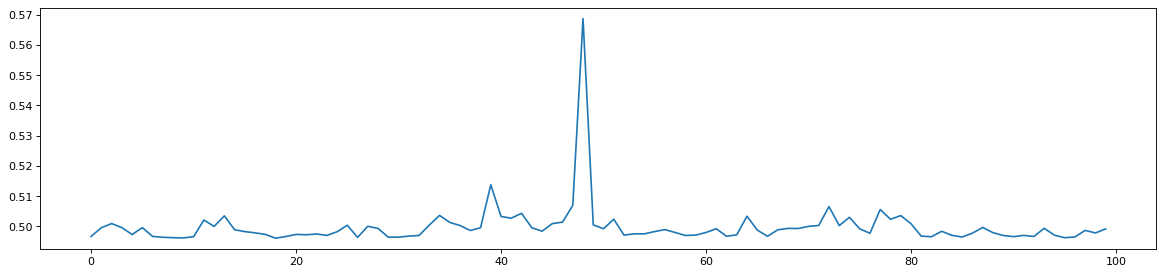

In [27]:
#used for Linear_LSTM to plot fc1 output
emb = emdx
fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(emb.cpu().detach().numpy()[0:100], label='t')
# plt.ylim(0.58, 0.68)


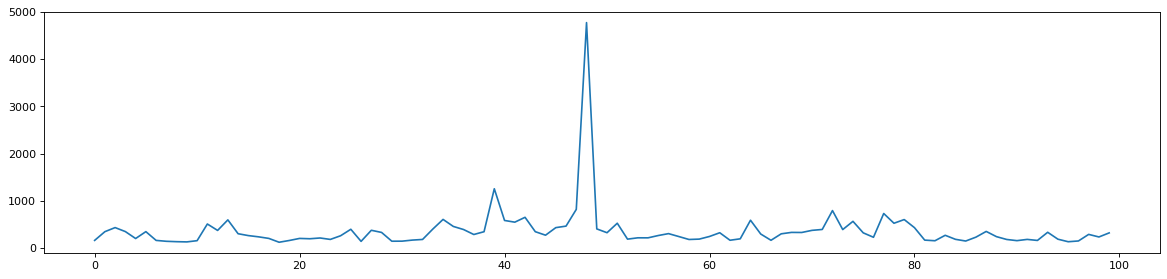

In [345]:
#used for Linear_LSTM to plot fc1 output
emb = emdx
fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(emb.cpu().detach().numpy()[0:100], label='t')
# plt.ylim(0.58, 0.68)

In [302]:
emdx

tensor([[ 165.9200],
        [ 350.5600],
        [ 436.9600],
        [ 352.3200],
        [ 205.7600],
        [ 351.2000],
        [ 165.9200],
        [ 147.0400],
        [ 138.8800],
        [ 134.2400],
        [ 160.1600],
        [ 512.8000],
        [ 376.9600],
        [ 600.0000],
        [ 307.0400],
        [ 267.6800],
        [ 241.2800],
        [ 208.0000],
        [ 127.0400],
        [ 164.3200],
        [ 207.8400],
        [ 200.8000],
        [ 216.9600],
        [ 186.7200],
        [ 264.1600],
        [ 401.2800],
        [ 145.6000],
        [ 380.0000],
        [ 334.5600],
        [ 148.9600],
        [ 149.9200],
        [ 172.4800],
        [ 185.9200],
        [ 405.5999],
        [ 609.9200],
        [ 461.4400],
        [ 396.0000],
        [ 290.7200],
        [ 349.7600],
        [1258.2399],
        [ 587.6799],
        [ 551.6801],
        [ 654.4000],
        [ 350.2400],
        [ 276.0000],
        [ 435.8400],
        [ 468.1600],
        [ 821

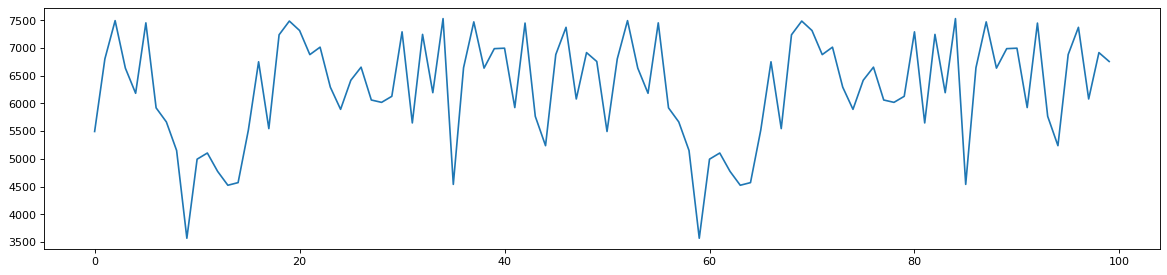

In [301]:
#used for Linear_LSTM to plot fc1 output
emb = embed_2
fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(emb.cpu().detach().numpy(), label='t')
# plt.ylim(0.58, 0.68)

In [166]:
# a = 0
# b = 45
# plt.plot(emb.cpu().detach().numpy().T[:,a], label="emb" +str(labels_batch.cpu().detach().numpy()[a])+str(a))
# plt.plot(emb.cpu().detach().numpy().T[:,b], label="emb2"+str(labels_batch.cpu().detach().numpy()[b])+str(b))
# plt.legend()
# plt.show()

In [ ]:
# embed_E.cpu().detach().numpy().shape

In [ ]:
embed_E.cpu().detach().numpy()[2].shape

In [ ]:
#used for Linear_CNN1D to plot fc1 output
emb = embed.view(64,-1)
fig=plt.figure(figsize=(18, 60), dpi= 80, facecolor='w', edgecolor='k')
for i in range(64):
    plt.subplot(32,2,i+1)
    plt.plot(emb.cpu().detach().numpy().T[:,i], label='t')

In [ ]:
# fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
# for i in range(embed_E.shape[1]):
#     plt.subplot(embed_E.shape[1],1,i+1)
#     plt.plot(embed_E.cpu().detach().numpy()[:,i], label='t')

In [ ]:
labels_batch.cpu().detach().numpy().T

In [ ]:
X_batch.shape

In [ ]:
labels_batch

In [ ]:
y_pred

In [ ]:
#####################
# Plot preds and performance
#####################
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

# plt.plot(y_pred.cpu().detach().numpy(), label="Preds")
# plt.plot(y_train.cpu().detach().numpy(), label="labels")
# plt.legend()
# plt.show() 



In [ ]:
#####################
# Plot preds and performance
#####################
# plt.plot(accuracy_train, label="accuracy_train")
# plt.plot(accuracy_test, label="accuracy_test")
# plt.plot(accuracy_val, label="accuracy_test")
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy  %')
# plt.legend()
# plt.show()

In [ ]:
train_predicts, train_labels, accuracy = predict(model, train_loader)
cm = metrics.confusion_matrix(train_labels, train_predicts)

fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
plt.show()

In [ ]:
test_predicts, test_labels, accuracy = predict(model, test_loader)
cm = metrics.confusion_matrix(test_labels, test_predicts)

fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
plt.show()